In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.parser import parse
from datetime import datetime, timedelta
import shapely

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%matplotlib inline

## Create Baseline

In [2]:
sfcrime = pd.read_csv('data/sfcrime_no_wc.csv')
sfcrime.head(1)

,Unnamed: 0,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Location,latitude,longitude,geometry,Neighborhoods,Hour,Day,Year,Type
0,0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 00:00:00,1900-01-01 14:00:00,MISSION,"(37.7617007179518, -122.42158168137)",37.761701,-122.421582,POINT (-122.42158168137 37.7617007179518),Mission,14,0,2015,OTHER


In [3]:
# Group crime by day, hour, neighborhood, and Type 
crime_type_count = sfcrime.groupby(["Day", "Hour", "Neighborhoods", "Type"])["IncidntNum"].count()
crime_type_count.head()

Day  Hour  Neighborhoods          Type       
0    0     Bayview Hunters Point  NON-VIOLENT    135
                                  OTHER          424
                                  PROPERTY       112
                                  VIOLENT        138
           Bernal Heights         NON-VIOLENT     63
Name: IncidntNum, dtype: int64

In [4]:
# Covert to dataframe
crime_type_count = crime_type_count.reset_index()
crime_type_count.head(2)

,Day,Hour,Neighborhoods,Type,IncidntNum
0,0,0,Bayview Hunters Point,NON-VIOLENT,135
1,0,0,Bayview Hunters Point,OTHER,424


In [5]:
#get number or incidents by day, hour, neighborhood
crime_by_neigh = sfcrime.groupby(["Day", "Hour", "Neighborhoods"])["IncidntNum"].count().reset_index()
crime_by_neigh.columns = ["Day", "Hour", "Neighborhoods", "NeighIncidntNum"]
crime_by_neigh.head(2)

,Day,Hour,Neighborhoods,NeighIncidntNum
0,0,0,Bayview Hunters Point,809
1,0,0,Bernal Heights,345


In [6]:
#merge df to get probility for crime type by the neigborhood
crime_prob = crime_type_count.merge(crime_by_neigh, on=["Day", "Hour", "Neighborhoods"])
crime_prob.head(2)

,Day,Hour,Neighborhoods,Type,IncidntNum,NeighIncidntNum
0,0,0,Bayview Hunters Point,NON-VIOLENT,135,809
1,0,0,Bayview Hunters Point,OTHER,424,809


In [7]:
#get probility
crime_prob["CrimeProbInNeigh"] = crime_prob['IncidntNum']/crime_prob['NeighIncidntNum']
crime_prob.head(2)

,Day,Hour,Neighborhoods,Type,IncidntNum,NeighIncidntNum,CrimeProbInNeigh
0,0,0,Bayview Hunters Point,NON-VIOLENT,135,809,0.166873
1,0,0,Bayview Hunters Point,OTHER,424,809,0.524104


In [8]:
# santiy check probabilities
bayviewF0 = (crime_prob['Day'] == 0) & (crime_prob['Hour'] == 0) & (crime_prob['Neighborhoods'] == 'Bayview Hunters Point')
crime_prob[bayviewF0]["CrimeProbInNeigh"].sum()

1.0

## Prepare Data

In [9]:
del sfcrime['Unnamed: 0']
sfcrime.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Location,latitude,longitude,geometry,Neighborhoods,Hour,Day,Year,Type
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 00:00:00,1900-01-01 14:00:00,MISSION,"(37.7617007179518, -122.42158168137)",37.761701,-122.421582,POINT (-122.42158168137 37.7617007179518),Mission,14,0,2015,OTHER
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 00:00:00,1900-01-01 15:45:00,TENDERLOIN,"(37.7841907151119, -122.414406029855)",37.784191,-122.414406,POINT (-122.414406029855 37.7841907151119),Tenderloin,15,6,2015,VIOLENT


In [10]:
#use a pivot table
incidence_by_nhood = \
pd.pivot_table(sfcrime, 
               values=['IncidntNum'], 
               columns=['Neighborhoods', 'Day', 'Hour', 'latitude', 'longitude'], 
               index=['Type'], 
               aggfunc='count')

In [11]:
incidence_by_nhood.head()

IncidntNum                                      \
Neighborhoods Bayview Hunters Point                                       
Day                               0                                       
Hour                             0                                        
latitude                  37.709971   37.710198   37.710368   37.710700   
longitude               -122.396282 -122.397242 -122.390889 -122.397460   
Type                                                                      
NON-VIOLENT                     NaN         NaN         NaN         NaN   
OTHER                           1.0         NaN         1.0         NaN   
PROPERTY                        NaN         1.0         NaN         1.0   
VIOLENT                         NaN         NaN         NaN         NaN   

                                                                           \
Neighborhoods                                                               
Day                                                                         
Hour                                                                        
latitude        37.710732   37.710757   37.711051   37.711141   37.711147   
longitude     -122.397592 -122.390793 -122.401061 -122.399313 -122.396884   
Type                                                                        
NON-VIOLENT           NaN         NaN         NaN         NaN         NaN   
OTHER                 1.0         1.0         1.0         NaN         1.0   
PROPERTY              NaN         NaN         NaN         1.0         NaN   
VIOLENT               NaN         NaN         NaN         NaN         NaN   

                              ...                                   \
Neighborhoods                 ...     Western Addition               
Day                           ...                    6               
Hour                          ...                   23               
latitude        37.711346     ...            37.788966   37.789043   
longitude     -122.400176     ...          -122.423803 -122.424607   
Type                          ...                                    
NON-VIOLENT           NaN     ...                  1.0         NaN   
OTHER                 NaN     ...                  NaN         1.0   
PROPERTY              NaN     ...                  NaN         NaN   
VIOLENT               1.0     ...                  NaN         NaN   

                                                                           \
Neighborhoods                                                               
Day                                                                         
Hour                                                                        
latitude        37.789151   37.789203   37.789411   37.789491   37.789682   
longitude     -122.424629 -122.423785 -122.422140 -122.425453 -122.423948   
Type                                                                        
NON-VIOLENT           NaN         1.0         1.0         NaN         NaN   
OTHER                 NaN         NaN         3.0         1.0         1.0   
PROPERTY              1.0         NaN         NaN         1.0         NaN   
VIOLENT               NaN         NaN         NaN         NaN         NaN   

                                                   
Neighborhoods                                      
Day                                                
Hour                                               
latitude        37.790000   37.790209   37.790369  
longitude     -122.424800 -122.423157 -122.422330  
Type                                               
NON-VIOLENT           NaN         NaN         3.0  
OTHER                 1.0         NaN         5.0  
PROPERTY              NaN         1.0         NaN  
VIOLENT               NaN         NaN         NaN  

[4 rows x 846185 columns]

In [12]:
crime_pivot = pd.DataFrame(incidence_by_nhood.unstack()).reset_index()
del crime_pivot['level_0']
crime_pivot.columns = ['Neighborhoods', 'Day','Hour','latitude', 'longitude', 'Type', 'CrimeHappened']
crime_pivot.head(2)

,Neighborhoods,Day,Hour,latitude,longitude,Type,CrimeHappened
0,Bayview Hunters Point,0,0,37.709971,-122.396282,NON-VIOLENT,NaN
1,Bayview Hunters Point,0,0,37.709971,-122.396282,OTHER,1.0


In [13]:
crime_pivot.fillna(value=0, inplace=True)
crime_pivot.head()

,Neighborhoods,Day,Hour,latitude,longitude,Type,CrimeHappened
0,Bayview Hunters Point,0,0,37.709971,-122.396282,NON-VIOLENT,0.0
1,Bayview Hunters Point,0,0,37.709971,-122.396282,OTHER,1.0
2,Bayview Hunters Point,0,0,37.709971,-122.396282,PROPERTY,0.0
3,Bayview Hunters Point,0,0,37.709971,-122.396282,VIOLENT,0.0
4,Bayview Hunters Point,0,0,37.710198,-122.397242,NON-VIOLENT,0.0


In [14]:
#pd.DataFrame(crime_pivot).to_csv('data/crime_pivot.csv')

In [15]:
crime_pivot.shape

(3384740, 7)

### Get sample of data to train

In [16]:
sf_test = crime_pivot.sample(1000000)
y = sf_test[['CrimeHappened']]
sf_test_X = sf_test[['Neighborhoods','Day','Hour','latitude','longitude','Type']]

In [17]:
y['CrimeHappened'] = y['CrimeHappened'].apply(lambda x: 1 if x >= 1 else 0)

/Users/lana/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
sf_test_X.head()

,Neighborhoods,Day,Hour,latitude,longitude,Type
596718,Excelsior,5,17,37.722430,-122.427912,PROPERTY
3202546,West of Twin Peaks,2,10,37.738609,-122.448768,PROPERTY
1680561,Mission,6,4,37.766959,-122.416011,OTHER
134937,Bayview Hunters Point,3,15,37.727899,-122.371476,OTHER
2848352,Sunset/Parkside,4,0,37.750335,-122.500990,NON-VIOLENT


In [19]:
y.head()

,CrimeHappened
596718,1
3202546,0
1680561,1
134937,0
2848352,1


In [20]:
sf_test_X = pd.get_dummies(sf_test_X)
print y.shape
print sf_test_X.shape

(1000000, 1)
(1000000, 49)


### train_test_split data and baseline

In [21]:
X_train, X_test, y_train, y_test = train_test_split(sf_test_X, y, test_size=0.3, random_state=14)

In [22]:
# Baseline probabilites
sfcrime_prob = crime_prob[["Day", "Hour", "Neighborhoods", 'Type', 'CrimeProbInNeigh']]
sfcrime_prob.head(2)

,Day,Hour,Neighborhoods,Type,CrimeProbInNeigh
0,0,0,Bayview Hunters Point,NON-VIOLENT,0.166873
1,0,0,Bayview Hunters Point,OTHER,0.524104


In [23]:
#pd.DataFrame(sfcrime_prob).to_csv('data/sfcrime_prob.csv')

In [24]:
X_test.head(2)

,Day,Hour,latitude,longitude,Neighborhoods_Bayview Hunters Point,Neighborhoods_Bernal Heights,Neighborhoods_Castro/Upper Market,Neighborhoods_Chinatown,Neighborhoods_Excelsior,Neighborhoods_Financial District/South Beach,...,Neighborhoods_Tenderloin,Neighborhoods_Treasure Island,Neighborhoods_Twin Peaks,Neighborhoods_Visitacion Valley,Neighborhoods_West of Twin Peaks,Neighborhoods_Western Addition,Type_NON-VIOLENT,Type_OTHER,Type_PROPERTY,Type_VIOLENT
1429899,1,5,37.749695,-122.420360,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2155040,0,15,37.772313,-122.509895,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
x_test_tomerge = X_test.reset_index(level=0)
x_test_tomerge = x_test_tomerge.rename(columns={'index': 'idx'})
x_test_tomerge.head(2)

,idx,Day,Hour,latitude,longitude,Neighborhoods_Bayview Hunters Point,Neighborhoods_Bernal Heights,Neighborhoods_Castro/Upper Market,Neighborhoods_Chinatown,Neighborhoods_Excelsior,...,Neighborhoods_Tenderloin,Neighborhoods_Treasure Island,Neighborhoods_Twin Peaks,Neighborhoods_Visitacion Valley,Neighborhoods_West of Twin Peaks,Neighborhoods_Western Addition,Type_NON-VIOLENT,Type_OTHER,Type_PROPERTY,Type_VIOLENT
0,1429899,1,5,37.749695,-122.420360,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2155040,0,15,37.772313,-122.509895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [26]:
crime_pivot.head(2)

,Neighborhoods,Day,Hour,latitude,longitude,Type,CrimeHappened
0,Bayview Hunters Point,0,0,37.709971,-122.396282,NON-VIOLENT,0.0
1,Bayview Hunters Point,0,0,37.709971,-122.396282,OTHER,1.0


In [27]:
crime_pivot_reindex = crime_pivot.reset_index(level=0)
crime_pivot_reindex = crime_pivot_reindex.rename(columns={'index': 'idx'})
crime_pivot_reindex.head(2)

,idx,Neighborhoods,Day,Hour,latitude,longitude,Type,CrimeHappened
0,0,Bayview Hunters Point,0,0,37.709971,-122.396282,NON-VIOLENT,0.0
1,1,Bayview Hunters Point,0,0,37.709971,-122.396282,OTHER,1.0


In [28]:
idxMerge = x_test_tomerge.merge(crime_pivot_reindex, on=['idx'])
idxMerge.head(2)

,idx,Day_x,Hour_x,latitude_x,longitude_x,Neighborhoods_Bayview Hunters Point,Neighborhoods_Bernal Heights,Neighborhoods_Castro/Upper Market,Neighborhoods_Chinatown,Neighborhoods_Excelsior,...,Type_OTHER,Type_PROPERTY,Type_VIOLENT,Neighborhoods,Day_y,Hour_y,latitude_y,longitude_y,Type,CrimeHappened
0,1429899,1,5,37.749695,-122.420360,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,Mission,1,5,37.749695,-122.420360,VIOLENT,0.0
1,2155040,0,15,37.772313,-122.509895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Outer Richmond,0,15,37.772313,-122.509895,NON-VIOLENT,0.0


In [29]:
base_test_merge = idxMerge.merge(sfcrime_prob, left_on=['Day_y', 'Hour_y', 'Neighborhoods', 'Type'], right_on=['Day', 'Hour', 'Neighborhoods', 'Type'])
base_test_merge.head(2)

,idx,Day_x,Hour_x,latitude_x,longitude_x,Neighborhoods_Bayview Hunters Point,Neighborhoods_Bernal Heights,Neighborhoods_Castro/Upper Market,Neighborhoods_Chinatown,Neighborhoods_Excelsior,...,Neighborhoods,Day_y,Hour_y,latitude_y,longitude_y,Type,CrimeHappened,Day,Hour,CrimeProbInNeigh
0,1429899,1,5,37.749695,-122.420360,0.0,0.0,0.0,0.0,0.0,...,Mission,1,5,37.749695,-122.420360,VIOLENT,0.0,1,5,0.141975
1,1430071,1,5,37.757065,-122.419322,0.0,0.0,0.0,0.0,0.0,...,Mission,1,5,37.757065,-122.419322,VIOLENT,0.0,1,5,0.141975


In [30]:
y_test.shape

(300000, 1)

In [31]:
y_test_merge = y_test.reset_index()
y_test_merge = y_test_merge.rename(columns={'index': 'idx'})
y_test_merge.head(2)

,idx,CrimeHappened
0,1429899,0
1,2155040,0


In [32]:
base = y_test_merge.merge(base_test_merge, on='idx', how='right')

In [33]:
base.head(2)

,idx,CrimeHappened_x,Day_x,Hour_x,latitude_x,longitude_x,Neighborhoods_Bayview Hunters Point,Neighborhoods_Bernal Heights,Neighborhoods_Castro/Upper Market,Neighborhoods_Chinatown,...,Neighborhoods,Day_y,Hour_y,latitude_y,longitude_y,Type,CrimeHappened_y,Day,Hour,CrimeProbInNeigh
0,1429899,0,1,5,37.749695,-122.420360,0.0,0.0,0.0,0.0,...,Mission,1,5,37.749695,-122.420360,VIOLENT,0.0,1,5,0.141975
1,2155040,0,0,15,37.772313,-122.509895,0.0,0.0,0.0,0.0,...,Outer Richmond,0,15,37.772313,-122.509895,NON-VIOLENT,0.0,0,15,0.245675


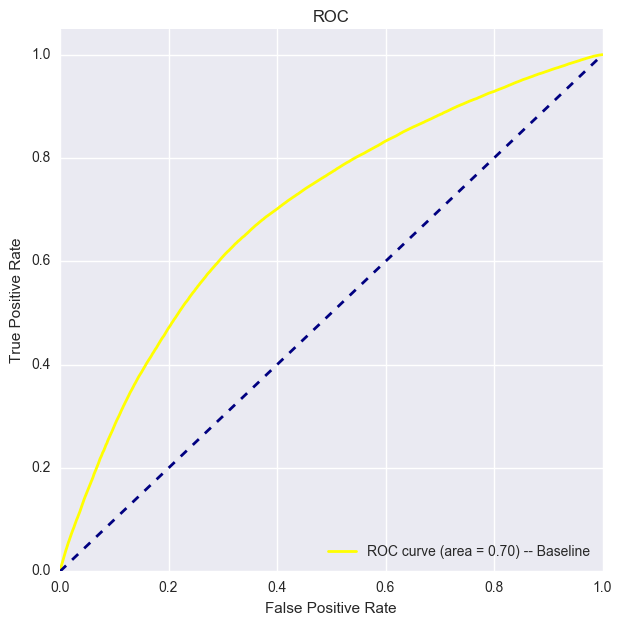

In [34]:
fpr_base, tpr_base, thresholds_b = roc_curve(base['CrimeHappened_x'], base['CrimeProbInNeigh'])

auc_base = auc(fpr_base, tpr_base)
    
plt.figure(figsize = (7,7))
lw = 2
plt.plot(fpr_base, tpr_base, color='yellow', lw=lw, label='ROC curve (area = %0.2f) -- Baseline' % auc_base)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression with sample data set

In [35]:
y = np.ravel(y)

In [36]:
logreg = LogisticRegression()
logreg = logreg.fit(sf_test_X, y)
logreg.score(sf_test_X, y)

0.66969599999999996

In [167]:
lr_coef = pd.DataFrame(zip(sf_test_X.columns, np.transpose(logreg.coef_)))
lr_coef.columns = ['Features','Importances']
lr_coef['Importances'] = lr_coef['Importances'].apply(lambda x: x[0])
lr_coef.head()

,Features,Importances
0,Day,0.004312
1,Hour,0.005237
2,latitude,0.143813
3,longitude,0.051175
4,Neighborhoods_Bayview Hunters Point,0.065469


In [169]:
flr_coef = lr_coef.sort_values(by='Importances', ascending=False).head(5)
flr_coef

,Features,Importances
39,Neighborhoods_Tenderloin,0.819288
46,Type_OTHER,0.705314
40,Neighborhoods_Treasure Island,0.676657
45,Type_NON-VIOLENT,0.523479
37,Neighborhoods_South of Market,0.371897


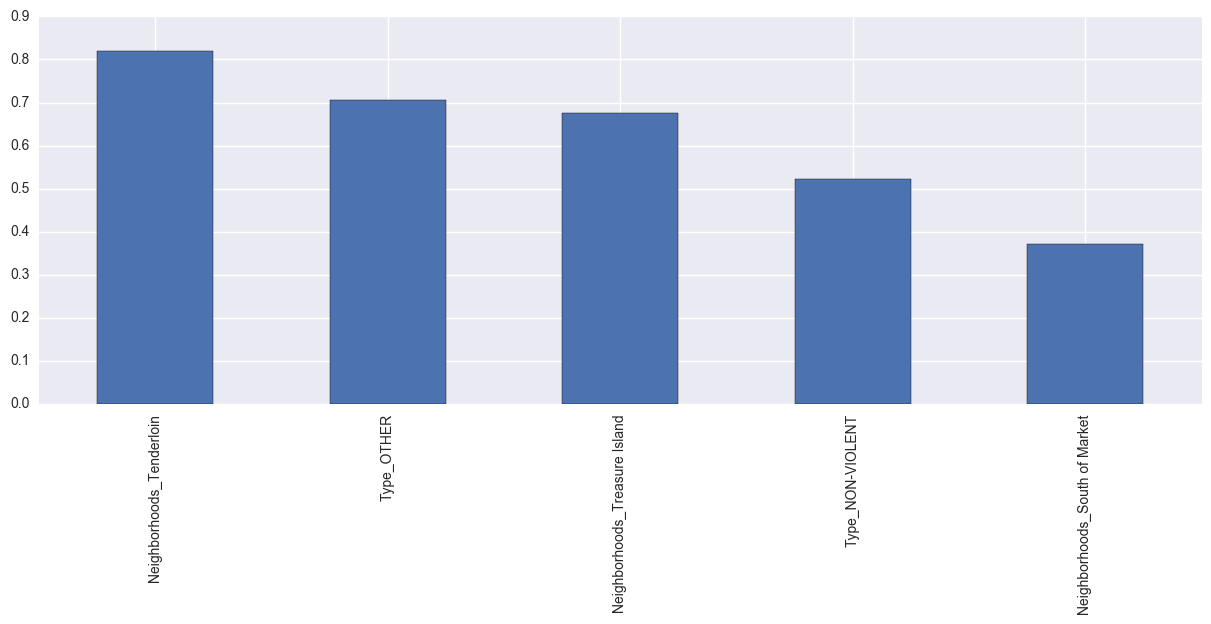

In [166]:
flr_coef.plot(kind ='bar', figsize=(15,5) , x='Features', y='Importances', legend=False, rot=90)
plt.xlabel("")
plt.show()

In [ ]:
fig = figure()
ax = fig.add_subplot(111)
ax.bar( [0,1,2], [1,3,5] )
ax.set_xticks( [ 0.5, 1.5, 2.5 ] )
ax.set_xticklabels( [‘tom’,‘dick’,‘harry’], rotation=45 ) ;

In [137]:
feats

array([  7.90621689e-02,   1.50213110e-01,   3.32203649e-01,
         3.27736743e-01,   2.09860405e-03,   7.33614389e-04,
         4.45621936e-04,   3.75066215e-04,   1.11882646e-03,
         9.94041574e-04,   3.03176375e-04,   3.28262094e-04,
         3.84382213e-04,   5.08224833e-04,   3.69341179e-04,
         3.04099434e-04,   2.90246260e-04,   3.88563472e-04,
         6.42912139e-05,   3.21228492e-04,   5.62671083e-04,
         1.81386257e-04,   1.08851971e-03,   2.58464079e-04,
         4.29306560e-04,   5.53699743e-04,   3.42960703e-04,
         2.56027855e-04,   5.05464054e-04,   5.35502381e-04,
         6.92632476e-04,   5.67062410e-04,   4.65731415e-04,
         7.22434134e-05,   3.06646677e-04,   4.52770038e-04,
         1.25958933e-04,   8.97433968e-04,   5.99198012e-04,
         6.37807490e-03,   8.04003710e-05,   2.44820984e-04,
         7.96201630e-04,   4.11350425e-04,   7.50076347e-04,
         1.85253666e-02,   3.03877376e-02,   1.33951783e-02,
         2.18938517e-02]

### Logistic Regression with train_test_split

In [39]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/lana/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
predicted = lr.predict(X_test)
probs = lr.predict_proba(X_test)
# lr.class_
# [1, 0]
print predicted
print probs

[0 0 0 ..., 0 0 0]
[[ 0.79235552  0.20764448]
 [ 0.59724406  0.40275594]
 [ 0.5838201   0.4161799 ]
 ..., 
 [ 0.81501413  0.18498587]
 [ 0.76201419  0.23798581]
 [ 0.55142451  0.44857549]]


In [41]:
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.669943333333
0.678957077626


In [42]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[173913  21360]
 [ 77657  27070]]
             precision    recall  f1-score   support

          0       0.69      0.89      0.78    195273
          1       0.56      0.26      0.35    104727

avg / total       0.65      0.67      0.63    300000



In [43]:
sf_test_X.shape, y.shape

((1000000, 49), (1000000,))

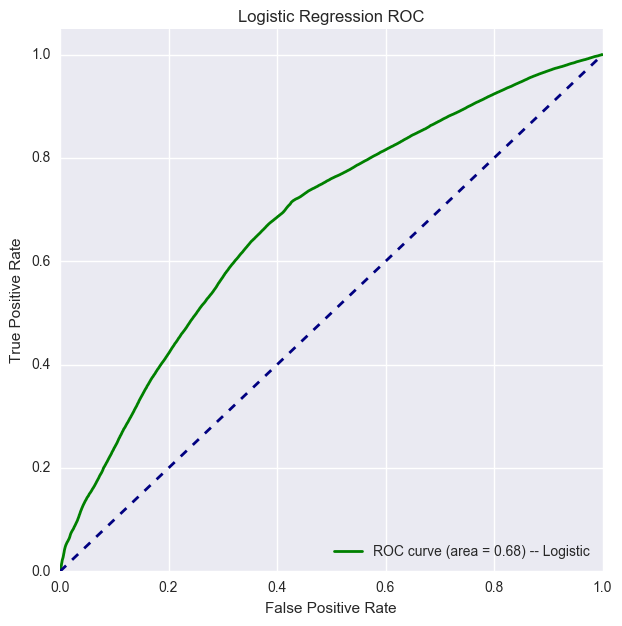

In [44]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, probs.T[1])

auc_lr = auc(fpr_lr, tpr_lr)
  
plt.figure(figsize = (7,7))
lw = 2
plt.plot(fpr_lr, tpr_lr, color='green', lw=lw, label='ROC curve (area = %0.2f) -- Logistic' % auc_lr)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="lower right")
plt.show()

In [45]:
scores = cross_val_score(LogisticRegression(), sf_test_X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.66799332  0.6701733   0.66884331  0.66926331  0.66911     0.67026
  0.66943669  0.66912669  0.67061671  0.67207672]
0.669690004984


## Random Forest

In [46]:
y_train = np.ravel(y_train)

In [47]:
# instatiate model
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [48]:
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=4)
rfc_scores, np.mean(rfc_scores)

(array([ 0.67110474,  0.67349143,  0.67447429,  0.67158098]),
 0.67266285782320567)

In [152]:
rfc_fea = pd.DataFrame(zip(sf_test_X.columns, np.transpose(rfc.feature_importances_)))
rfc_fea.columns = ['Features','Importances']

In [153]:
rfc_fea.sort_values(by='Importances', ascending=False).head(5)

,Features,Importances
2,latitude,0.332204
3,longitude,0.327737
1,Hour,0.150213
0,Day,0.079062
46,Type_OTHER,0.030388


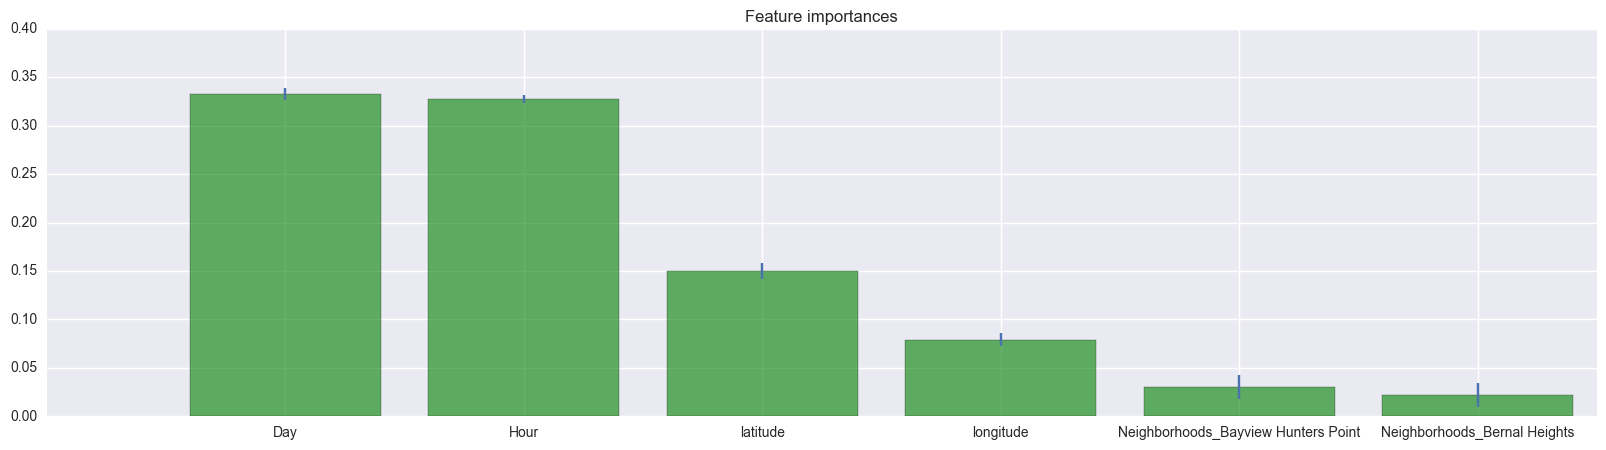

In [154]:
feats = rfc.feature_importances_
## rfc3.estimators_ --> list of Decision Tree Classifer Instances 
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],axis=0)
indices = np.argsort(feats)[::-1]

plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(len(feats)), feats[indices], color="g", yerr=std[indices], align='center', width=-0.8, alpha=0.6)
plt.xticks(range(len(feats)), rfc_fea.Features)
plt.xlim([-1, 5.5])
plt.ylim([0,.40])
plt.show()

In [49]:
predicted = rfc.predict(X_test)
probs = rfc.predict_proba(X_test)
print predicted
print probs

[0 1 0 ..., 0 0 0]
[[ 0.9  0.1]
 [ 0.3  0.7]
 [ 0.8  0.2]
 ..., 
 [ 0.9  0.1]
 [ 0.6  0.4]
 [ 0.9  0.1]]


In [50]:
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.672606666667
0.666998287968


In [51]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[161660  33613]
 [ 64605  40122]]
             precision    recall  f1-score   support

          0       0.71      0.83      0.77    195273
          1       0.54      0.38      0.45    104727

avg / total       0.66      0.67      0.66    300000



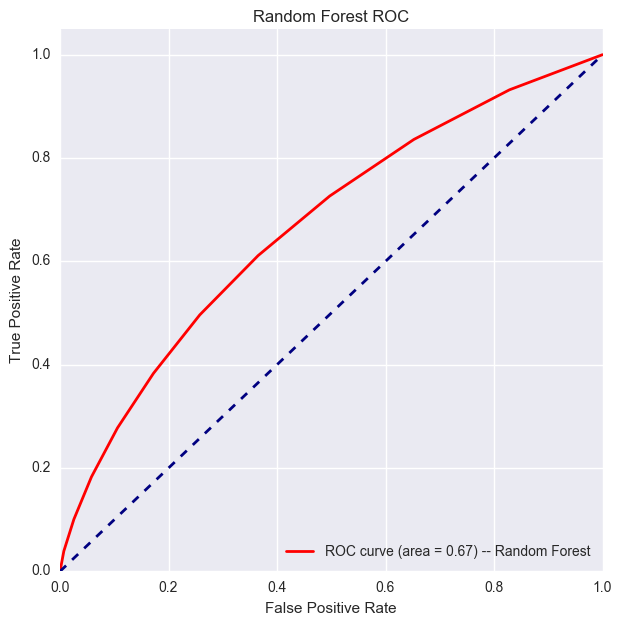

In [52]:
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, probs.T[1])

auc_rfc = auc(fpr_rfc, tpr_rfc)
    
plt.figure(figsize = (7,7))
lw = 2
plt.plot(fpr_rfc, tpr_rfc, color='red',
         lw=lw, label='ROC curve (area = %0.2f) -- Random Forest' % auc_rfc)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
plt.show()

In [53]:
scores = cross_val_score(rfc, sf_test_X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.67360326  0.67452325  0.67480325  0.67395326  0.67496     0.67406
  0.67604676  0.67409674  0.67573676  0.67337673]
0.674516002374


## Gradient Boosting

In [54]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [55]:
gbc_scores = cross_val_score(gbc, X_train, y_train, cv=4)
gbc_scores, np.mean(gbc_scores)

(array([ 0.69084748,  0.69166857,  0.69107429,  0.69109538]),
 0.69117142892556704)

In [157]:
gbc_fea = pd.DataFrame(zip(sf_test_X.columns, np.transpose(gbc.feature_importances_)))
gbc_fea.columns = ['Features','Importances']

In [158]:
gbc_fea.sort_values(by='Importances', ascending=False).head(5)

,Features,Importances
2,latitude,0.208859
3,longitude,0.190110
45,Type_NON-VIOLENT,0.154059
1,Hour,0.088049
46,Type_OTHER,0.075126


In [56]:
predicted = gbc.predict(X_test)
probs = gbc.predict_proba(X_test)

In [57]:
print gbc.classes_
print predicted
print probs

[0 1]
[0 1 0 ..., 0 0 0]
[[ 0.77739633  0.22260367]
 [ 0.49447596  0.50552404]
 [ 0.51419906  0.48580094]
 ..., 
 [ 0.86479421  0.13520579]
 [ 0.82335037  0.17664963]
 [ 0.58521321  0.41478679]]


In [58]:
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.692656666667
0.704623246033


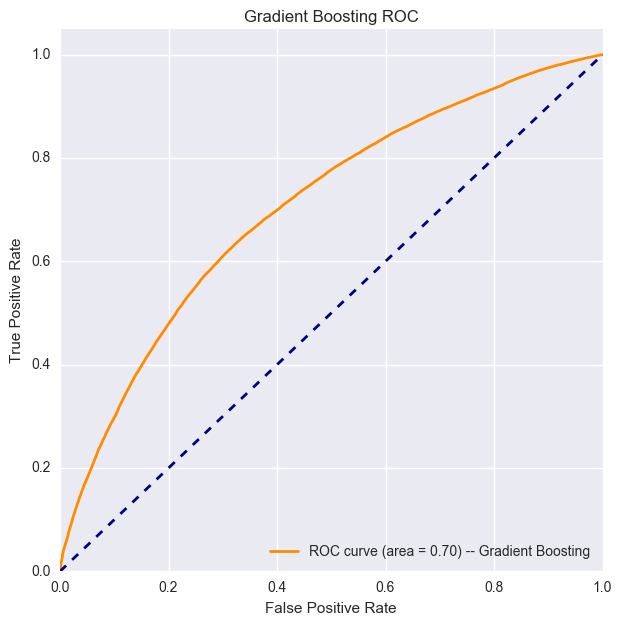

In [59]:
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, probs.T[1])

auc_gbc = auc(fpr_gbc, tpr_gbc)
    
plt.figure(figsize = (7,7))
lw = 2
plt.plot(fpr_gbc, tpr_gbc, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f) -- Gradient Boosting' % auc_gbc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC')
plt.legend(loc="lower right")
plt.show()

In [60]:
scores = cross_val_score(gbc, sf_test_X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.69162308  0.69205308  0.6902931   0.69336307  0.69153     0.68992
  0.69300693  0.69197692  0.69256693  0.69139691]
0.691773001615


### All Models ROC

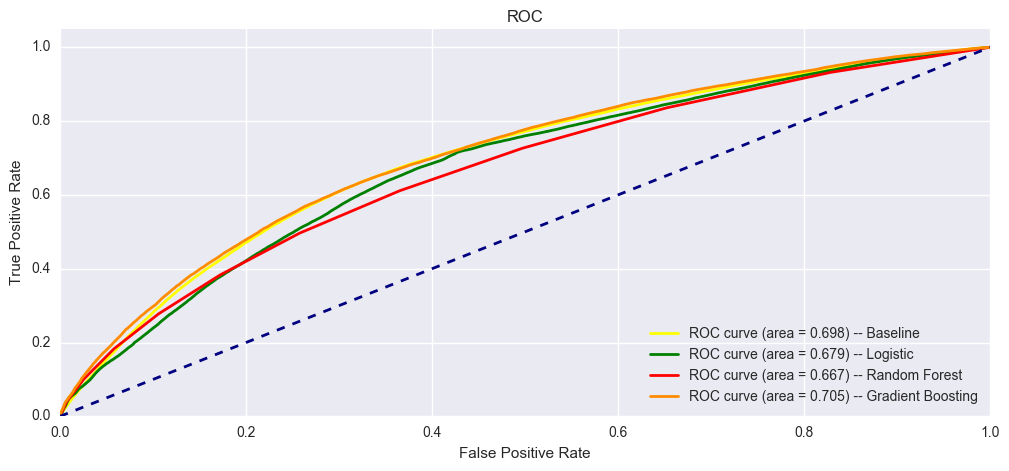

In [61]:
plt.figure(figsize = (12,5))
lw = 2
plt.plot(fpr_base, tpr_base, color='yellow', lw=lw, label='ROC curve (area = %0.3f) -- Baseline' % auc_base)
plt.plot(fpr_lr, tpr_lr, color='green', lw=lw, label='ROC curve (area = %0.3f) -- Logistic' % auc_lr)
plt.plot(fpr_rfc, tpr_rfc, color='red', lw=lw, label='ROC curve (area = %0.3f) -- Random Forest' % auc_rfc)
plt.plot(fpr_gbc, tpr_gbc, color='darkorange', lw=lw, label='ROC curve (area = %0.3f) -- Gradient Boosting' % auc_gbc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show();

### Get Probabilities from Gradient Boost

In [62]:
probsdf = pd.DataFrame(probs)
probsdf.head()

,0,1
0,0.777396,0.222604
1,0.494476,0.505524
2,0.514199,0.485801
3,0.741690,0.258310
4,0.511082,0.488918


In [63]:
X_test_df = X_test.reset_index()
X_test_df.head()

,index,Day,Hour,latitude,longitude,Neighborhoods_Bayview Hunters Point,Neighborhoods_Bernal Heights,Neighborhoods_Castro/Upper Market,Neighborhoods_Chinatown,Neighborhoods_Excelsior,...,Neighborhoods_Tenderloin,Neighborhoods_Treasure Island,Neighborhoods_Twin Peaks,Neighborhoods_Visitacion Valley,Neighborhoods_West of Twin Peaks,Neighborhoods_Western Addition,Type_NON-VIOLENT,Type_OTHER,Type_PROPERTY,Type_VIOLENT
0,1429899,1,5,37.749695,-122.420360,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2155040,0,15,37.772313,-122.509895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1360088,6,10,37.800482,-122.425987,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2433370,4,17,37.759259,-122.387508,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,435756,5,16,37.762549,-122.434063,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [64]:
X_test_prob_df = pd.concat([X_test_df,probsdf], axis=1,)
X_test_prob_df.head()

,index,Day,Hour,latitude,longitude,Neighborhoods_Bayview Hunters Point,Neighborhoods_Bernal Heights,Neighborhoods_Castro/Upper Market,Neighborhoods_Chinatown,Neighborhoods_Excelsior,...,Neighborhoods_Twin Peaks,Neighborhoods_Visitacion Valley,Neighborhoods_West of Twin Peaks,Neighborhoods_Western Addition,Type_NON-VIOLENT,Type_OTHER,Type_PROPERTY,Type_VIOLENT,0,1
0,1429899,1,5,37.749695,-122.420360,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.777396,0.222604
1,2155040,0,15,37.772313,-122.509895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.494476,0.505524
2,1360088,6,10,37.800482,-122.425987,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.514199,0.485801
3,2433370,4,17,37.759259,-122.387508,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.741690,0.258310
4,435756,5,16,37.762549,-122.434063,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.511082,0.488918


In [65]:
McLarenPark = X_test_prob_df[X_test_prob_df['Neighborhoods_McLaren Park'] == 1]
McLarenPark.head()

,index,Day,Hour,latitude,longitude,Neighborhoods_Bayview Hunters Point,Neighborhoods_Bernal Heights,Neighborhoods_Castro/Upper Market,Neighborhoods_Chinatown,Neighborhoods_Excelsior,...,Neighborhoods_Twin Peaks,Neighborhoods_Visitacion Valley,Neighborhoods_West of Twin Peaks,Neighborhoods_Western Addition,Type_NON-VIOLENT,Type_OTHER,Type_PROPERTY,Type_VIOLENT,0,1
865,1369550,0,15,37.715282,-122.414476,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.773432,0.226568
1004,1371211,2,15,37.722665,-122.415672,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.770257,0.229743
1028,1370207,1,12,37.718512,-122.416213,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.778501,0.221499
1106,1373121,4,21,37.719743,-122.425592,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.577200,0.422800
2628,1369959,1,1,37.719992,-122.406999,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.729002,0.270998


In [66]:
del McLarenPark[0]
for col in McLarenPark.columns:
    cols = str(col)
    if 'Neighborhoods' in cols:
        del McLarenPark[col]

In [67]:
McLarenPark.head()

,index,Day,Hour,latitude,longitude,Type_NON-VIOLENT,Type_OTHER,Type_PROPERTY,Type_VIOLENT,1
865,1369550,0,15,37.715282,-122.414476,0.0,0.0,1.0,0.0,0.226568
1004,1371211,2,15,37.722665,-122.415672,0.0,0.0,0.0,1.0,0.229743
1028,1370207,1,12,37.718512,-122.416213,0.0,0.0,0.0,1.0,0.221499
1106,1373121,4,21,37.719743,-122.425592,0.0,1.0,0.0,0.0,0.422800
2628,1369959,1,1,37.719992,-122.406999,0.0,0.0,0.0,1.0,0.270998


In [68]:
del McLarenPark['index']

In [69]:
McLarenPark = McLarenPark.rename(columns = {1:'Crime_Probability'})

In [70]:
#pd.DataFrame(McLarenPark).to_csv('data/McLarenParkProbs.csv')

In [71]:
McLarenPark.shape

(495, 9)

In [72]:
McLarenParkmelt = pd.melt(McLarenPark, id_vars=['Day', 'Hour', 'latitude', 'longitude', 'Crime_Probability'])

In [73]:
McLarenParkmelt.head()

,Day,Hour,latitude,longitude,Crime_Probability,variable,value
0,0,15,37.715282,-122.414476,0.226568,Type_NON-VIOLENT,0.0
1,2,15,37.722665,-122.415672,0.229743,Type_NON-VIOLENT,0.0
2,1,12,37.718512,-122.416213,0.221499,Type_NON-VIOLENT,0.0
3,4,21,37.719743,-122.425592,0.422800,Type_NON-VIOLENT,0.0
4,1,1,37.719992,-122.406999,0.270998,Type_NON-VIOLENT,0.0


In [74]:
McLarenParkmelt = McLarenParkmelt[McLarenParkmelt['value'] == 1]

In [75]:
#pd.DataFrame(McLarenParkmelt).to_csv('data/McLarenParkProbs.csv')

In [76]:
McLarenParkmelt.describe()

,Day,Hour,latitude,longitude,Crime_Probability,value
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,2.844444,13.644444,37.717929,-122.416412,0.340861,1.0
std,2.018649,6.183991,0.003629,0.006385,0.132029,0.0
min,0.000000,0.000000,37.710103,-122.426956,0.178173,1.0
25%,1.000000,10.000000,37.715345,-122.423170,0.226240,1.0
50%,3.000000,14.000000,37.718754,-122.414476,0.305284,1.0
75%,4.000000,18.000000,37.719992,-122.411674,0.485687,1.0
max,6.000000,23.000000,37.724527,-122.406894,0.586427,1.0


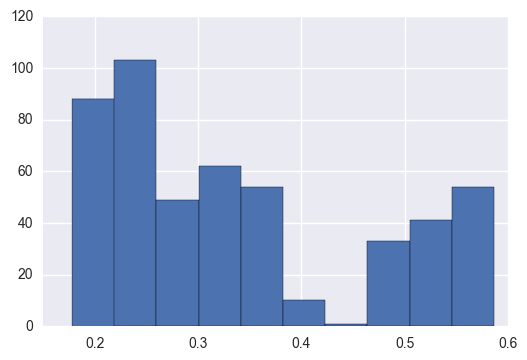

In [77]:
McLarenParkmelt.Crime_Probability.hist();